In [9]:
import pandas as pd
merged_df = pd.read_csv('Merged_DatasetV2.csv')
merged_df.head()

/var/folders/rf/qbnw5dmn5dq1gms0pls5p4b40000gn/T/ipykernel_28729/2551388421.py:2: DtypeWarning: Columns (4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  merged_df = pd.read_csv('Merged_DatasetV2.csv')


,Unnamed: 0,id,type,name,city,state,county,country,lifespan_years,status,services_offered
0,0,f9a1fd95-4c6d-43a6-bb31-4ee8d5a44a8b,Studio,Columbia (CBS) Studio ‘B’,Test Restaurant,New York,NaN,US,NaN,Active,NaN
1,1,42e9fa7c-a981-44f9-943c-bf39a8c6ce8d,Venue,New Theatre Oxford,Victoria House Hotel,England,Oxfordshire,GB,NaN,Active,NaN
2,2,34e7351d-715d-4b20-a5d6-3c0bd717eb1d,Religious building,Santuario della Beata Vergine di Ariadello,Genivolta,NaN,NaN,IT,359.0,Active,NaN
3,3,0ad32768-514b-410f-9d5a-40ebb0c3373c,Studio,ROKU-st,Tenso Jinja,NaN,NaN,JP,NaN,Active,NaN
4,4,0b050655-48da-4be7-b5de-7a3ee7370b9e,Venue,Rätschenmühle,Geislingen an der Steige,NaN,NaN,DE,NaN,Active,NaN


In [10]:
# Drop rows where 'services_offered' is null
merged_df = merged_df.dropna(subset=['services_offered'])

# Drop the specified columns
merged_df = merged_df.drop(columns=['Unnamed: 0', 'id', 'name'])

# Display the updated dataframe
merged_df.head()


,type,city,state,county,country,lifespan_years,status,services_offered
15520,Other,Los Jarales,NaN,NaN,VE,NaN,Active,recorded at
15521,Venue,Plasky,Brussels Capital,Bruxelles-Capitale,BE,62.0,Active,recorded at
15522,Other,Dunluce Castle,Northern Ireland,Causeway Coast and Glens,GB,NaN,Active,recorded at
15524,Studio,Saint Johns Eastern Orthodox Church,Tennessee,NaN,US,5.0,Ended,engineered at
15525,Venue,Shimokitazawa Eki,NaN,NaN,JP,34.0,Active,recorded at


In [11]:
# Ensure the column is string type and split by commas (handling spaces)
merged_df['services_offered'] = merged_df['services_offered'].astype(str).str.split(r',\s*')

# Explode the dataframe to have one service per row
merged_df = merged_df.explode('services_offered')

# Trim any leading or trailing spaces (just in case)
merged_df['services_offered'] = merged_df['services_offered'].str.strip()

# Drop any empty values that might have been created
merged_df = merged_df[merged_df['services_offered'].notna() & (merged_df['services_offered'] != '')]

# Reset index after exploding
merged_df = merged_df.reset_index(drop=True)


In [12]:
import re

# Function to remove the last word and underscore
def remove_last_part(text):
    return re.sub(r'_[^_]+$', '', text)  # Removes the last underscore and the word after it

# Apply the function to the column
merged_df['services_offered'] = merged_df['services_offered'].astype(str).apply(remove_last_part)

# Display the cleaned column
print(merged_df['services_offered'].unique())


['recorded at' 'engineered at' 'edited at' 'mixed at' 'video shot at'
 'lyrics written at' 'produced at' 'premiere' 'written at' 'commissioned'
 'composed at' 'arranged at' 'dedication' 'revised at' 'remixed at']


In [13]:
def impute_df(df):
    # Fill non-numeric columns with "Missing"
    cols_to_fill = df.columns.difference(['lifespan_years'])
    df[cols_to_fill] = df[cols_to_fill].fillna("Missing")
    
    # Create missing indicator for 'lifespan_years'
    df['lifespan_years_missing'] = df['lifespan_years'].isnull().astype(int)
    
    # Impute missing values in 'lifespan_years' with the median value
    median_val = df['lifespan_years'].median()
    df['lifespan_years'] = df['lifespan_years'].fillna(median_val)
    
    return df

In [14]:
from sklearn.model_selection import train_test_split


train_df, test_df = train_test_split(merged_df, test_size=0.2, random_state=42)


train_df = impute_df(train_df)
test_df = impute_df(test_df)

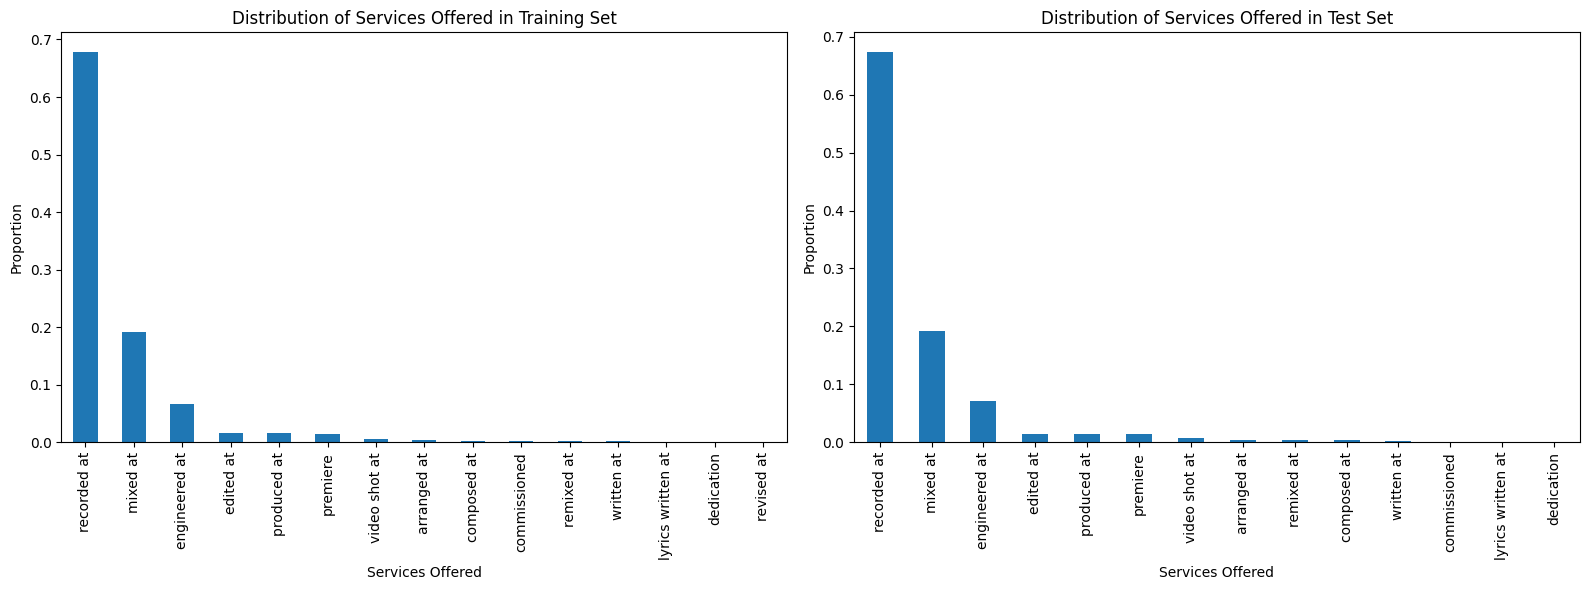

In [15]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Training set chart
train_counts = train_df['services_offered'].value_counts(normalize=True)
train_counts.plot(kind='bar', ax=axes[0])
axes[0].set_title("Distribution of Services Offered in Training Set")
axes[0].set_xlabel("Services Offered")
axes[0].set_ylabel("Proportion")

# Test set chart
test_counts = test_df['services_offered'].value_counts(normalize=True)
test_counts.plot(kind='bar', ax=axes[1])
axes[1].set_title("Distribution of Services Offered in Test Set")
axes[1].set_xlabel("Services Offered")
axes[1].set_ylabel("Proportion")

plt.tight_layout()
plt.show()

In [16]:
train_df['services_offered'].value_counts()

services_offered
recorded at          9339
mixed at             2645
engineered at         900
edited at             228
produced at           217
premiere              194
video shot at          81
arranged at            41
composed at            34
commissioned           26
remixed at             24
written at             23
lyrics written at       6
dedication              4
revised at              2
Name: count, dtype: int64

In [17]:
import xgboost as xgb
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assume train_df and test_df are already loaded.

# Transform your training data as before.
X_train = pd.get_dummies(train_df.drop(columns=["services_offered", "lifespan_years"]), drop_first=True)
X_train["lifespan_years"] = train_df["lifespan_years"]

# Use raw string notation to avoid escape sequence warnings
X_train.columns = X_train.columns.astype(str).str.replace(r"[,\[\]<>]", "_", regex=True)

# Similarly, transform the test data.
X_test = pd.get_dummies(test_df.drop(columns=["services_offered", "lifespan_years"]), drop_first=True)
X_test["lifespan_years"] = test_df["lifespan_years"]
X_test.columns = X_test.columns.astype(str).str.replace(r"[,\[\]<>]", "_", regex=True)

# Reindex X_test to have the same columns as X_train, filling missing columns with zeros.
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# Encode the target variable
le = LabelEncoder()
y_train = le.fit_transform(train_df["services_offered"])
y_test = le.fit_transform(test_df["services_offered"])

# Initialize the cross-validation scheme: here we're using 5 folds for demonstration.
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store metrics for each fold
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []

# Manual cross-validation loop
for fold, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train), 1):
    X_train_fold = X_train.iloc[train_idx]
    y_train_fold = y_train[train_idx]
    X_val_fold = X_train.iloc[val_idx]
    y_val_fold = y_train[val_idx]
    
    # Initialize and train the model (a fresh instance per fold)
    model = xgb.XGBClassifier(random_state=42)
    model.fit(X_train_fold, y_train_fold)
    
    # Predict on the validation fold
    preds = model.predict(X_val_fold)
    
    # Calculate metrics
    acc = accuracy_score(y_val_fold, preds)
    prec = precision_score(y_val_fold, preds, average='weighted', zero_division=0)
    rec = recall_score(y_val_fold, preds, average='weighted')
    f1 = f1_score(y_val_fold, preds, average='weighted')
    
    # Append the results for this fold
    accuracy_list.append(acc)
    precision_list.append(prec)
    recall_list.append(rec)
    f1_list.append(f1)
    
    print(f"Fold {fold}: Accuracy={acc:.4f}, Precision={prec:.4f}, Recall={rec:.4f}, F1 Score={f1:.4f}")

# Compute and print the average metrics across all folds
print("\nCross-Validation Results:")
print("Average Accuracy:", np.mean(accuracy_list))
print("Average Precision:", np.mean(precision_list))
print("Average Recall:", np.mean(recall_list))
print("Average F1 Score:", np.mean(f1_list))

# Now, if you wish to evaluate on the test set with the final model,
# you can train on the entire training set and then predict on X_test.
model = xgb.XGBClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Optionally, convert predictions back to original labels
y_test_labels = le.inverse_transform(y_test)
y_pred_labels = le.inverse_transform(y_pred)

# You can now use y_test_labels and y_pred_labels for further evaluation.


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Fold 1: Accuracy=0.6789, Precision=0.5751, Recall=0.6789, F1 Score=0.5850
Fold 2: Accuracy=0.6793, Precision=0.5869, Recall=0.6793, F1 Score=0.5915
Fold 3: Accuracy=0.6851, Precision=0.5962, Recall=0.6851, F1 Score=0.5949
Fold 4: Accuracy=0.6811, Precision=0.5792, Recall=0.6811, F1 Score=0.5862
Fold 5: Accuracy=0.6726, Precision=0.5582, Recall=0.6726, F1 Score=0.5786

Cross-Validation Results:
Average Accuracy: 0.679380501398052
Average Precision: 0.5791116284981315
Average Recall: 0.679380501398052
Average F1 Score: 0.5872643372329723


Across the 5 folds, the model’s average accuracy and recall indicates that it classifies the majority of examples correctly. The low precision scores are intriguing and indicate it may be worthwhile to follow up with a classification report for performance metrics across the target classes.

In [18]:
from sklearn.metrics import classification_report

# Print the classification report across all target classes
print(classification_report(y_test_labels, y_pred_labels))

                   precision    recall  f1-score   support

      arranged at       0.00      0.00      0.00        15
     commissioned       0.00      0.00      0.00         3
      composed at       0.00      0.00      0.00        10
       dedication       0.00      0.00      0.00         1
        edited at       0.12      0.02      0.03        51
    engineered at       0.32      0.03      0.06       243
lyrics written at       0.00      0.00      0.00         2
         mixed at       0.37      0.11      0.17       659
         premiere       0.00      0.00      0.00        46
      produced at       0.00      0.00      0.00        48
      recorded at       0.70      0.97      0.81      2321
       remixed at       0.00      0.00      0.00        11
    video shot at       0.00      0.00      0.00        23
       written at       0.00      0.00      0.00         9

         accuracy                           0.68      3442
        macro avg       0.11      0.08      0.08      

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

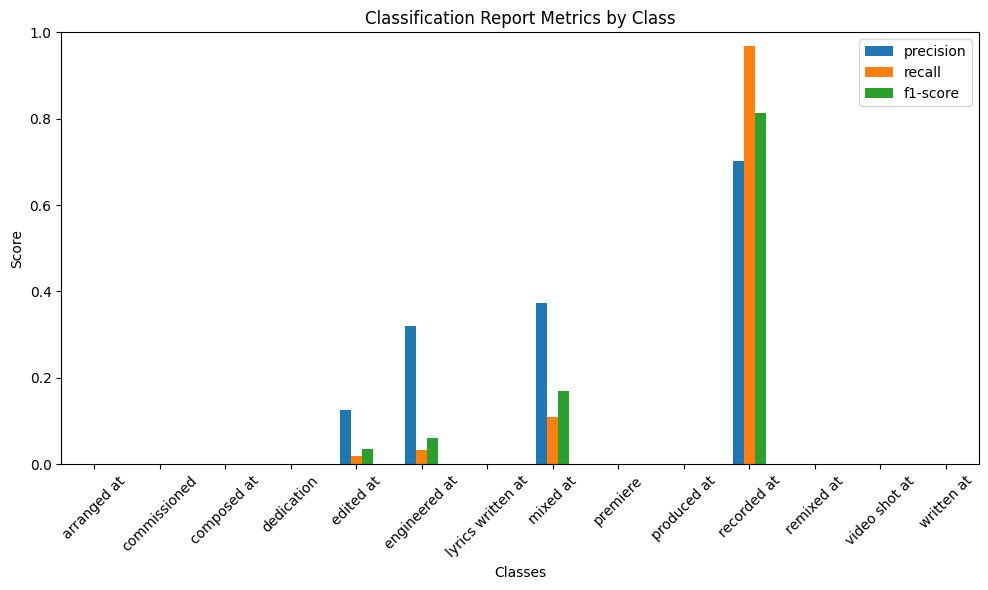

In [19]:
from sklearn.metrics import classification_report


# Compute classification report as a dictionary
report_dict = classification_report(y_test_labels, y_pred_labels, output_dict=True)

# Convert report to a DataFrame for easier plotting
report_df = pd.DataFrame(report_dict).transpose()

# Remove aggregate scores; we keep only per-class metrics (precision, recall, f1-score)
classes = report_df.drop(index=["accuracy", "macro avg", "weighted avg"])

# Plot grouped bar chart
classes[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(10,6))
plt.title('Classification Report Metrics by Class')
plt.ylabel('Score')
plt.xlabel('Classes')
plt.ylim(0,1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Based on the classification report, we can see that the model is biased toward the majority target class. There are two minority subclasses of interest for the target variable: moderate minorities like produced at, premiere, video shot at and extrame minorities. It makes sense to apply SMOTE for the moderate minorities and ADASYN fo rthe extreme minorities.

In [30]:

from imblearn.over_sampling import ADASYN, SMOTE
from collections import Counter

# Apply SMOTE to moderately imbalanced classes
# Ensure that the target sample size is not less than the current number of samples.
smote = SMOTE(sampling_strategy={'produced at': 1000, 'premiere': 1000, 'video shot at': 1000, 'edited at': 1000}, random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, train_df["services_offered"])


In [33]:
print("Before SMOTE:", Counter(train_df["services_offered"]))
print("After SMOTE:", Counter(y_train_smote))


Before SMOTE: Counter({'recorded at': 9339, 'mixed at': 2645, 'engineered at': 900, 'edited at': 228, 'produced at': 217, 'premiere': 194, 'video shot at': 81, 'arranged at': 41, 'composed at': 34, 'commissioned': 26, 'remixed at': 24, 'written at': 23, 'lyrics written at': 6, 'dedication': 4, 'revised at': 2})
After SMOTE: Counter({'recorded at': 9339, 'mixed at': 2645, 'produced at': 1000, 'edited at': 1000, 'premiere': 1000, 'video shot at': 1000, 'engineered at': 900, 'arranged at': 41, 'composed at': 34, 'commissioned': 26, 'remixed at': 24, 'written at': 23, 'lyrics written at': 6, 'dedication': 4, 'revised at': 2})


In [39]:

# Define thresholds: Only apply ADASYN to classes below 500 samples
adasyn_classes = ['arranged at', 'composed at', 
                  'commissioned', 'remixed at', 'written at', 'lyrics written at', 'dedication', 'revised at']
# Apply ADASYN to extremely imbalanced classes with a reduced number of neighbors to avoid errors on small classes
adasyn = ADASYN(n_neighbors=1, sampling_strategy={cls: 750 for cls in adasyn_classes}, random_state=42)
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train_smote, y_train_smote)

# Check new class distribution
print("After ADASYN + SMOTE:", Counter(y_train_resampled))

After ADASYN + SMOTE: Counter({'recorded at': 9339, 'mixed at': 2645, 'produced at': 1000, 'edited at': 1000, 'premiere': 1000, 'video shot at': 1000, 'engineered at': 900, 'remixed at': 759, 'composed at': 754, 'lyrics written at': 751, 'revised at': 750, 'dedication': 750, 'commissioned': 748, 'written at': 743, 'arranged at': 738})


Now that the minority classes have been strategically oversampled with SMOTE and ADASYN, it should also be helpful to undersample the overwhelming majority, recorded at.

In [40]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# Define undersampling strategy for "recorded at"
undersample = RandomUnderSampler(sampling_strategy={'recorded at': 2000, 'mixed at' : 2000}, random_state=42)

# Apply undersampling
X_final, y_final = undersample.fit_resample(X_train_resampled, y_train_resampled)

# Check new distribution
print("After Undersampling:", Counter(y_final))


After Undersampling: Counter({'mixed at': 2000, 'recorded at': 2000, 'edited at': 1000, 'premiere': 1000, 'produced at': 1000, 'video shot at': 1000, 'engineered at': 900, 'remixed at': 759, 'composed at': 754, 'lyrics written at': 751, 'dedication': 750, 'revised at': 750, 'commissioned': 748, 'written at': 743, 'arranged at': 738})


In [41]:
import xgboost as xgb
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Use X_final and y_final (assumed to be defined already from previous cells)
le = LabelEncoder()
y_encoded = le.fit_transform(y_final)

# X_final is already numeric (from oversampling/undersampling)
X = X_final

# Initialize the cross-validation scheme using 5 folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store metrics for each fold
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []

# Manual cross-validation loop
for fold, (train_idx, val_idx) in enumerate(cv.split(X, y_encoded), 1):
    X_train_fold = X.iloc[train_idx]
    y_train_fold = y_encoded[train_idx]
    X_val_fold = X.iloc[val_idx]
    y_val_fold = y_encoded[val_idx]
    
    # Initialize and train the model (a fresh instance per fold)
    model = xgb.XGBClassifier(random_state=42)
    model.fit(X_train_fold, y_train_fold)
    
    # Predict on the validation fold
    preds = model.predict(X_val_fold)
    
    # Calculate metrics
    acc = accuracy_score(y_val_fold, preds)
    prec = precision_score(y_val_fold, preds, average='weighted', zero_division=0)
    rec = recall_score(y_val_fold, preds, average='weighted')
    f1 = f1_score(y_val_fold, preds, average='weighted')
    
    # Append the results for this fold
    accuracy_list.append(acc)
    precision_list.append(prec)
    recall_list.append(rec)
    f1_list.append(f1)
    
    print(f"Fold {fold}: Accuracy={acc:.4f}, Precision={prec:.4f}, Recall={rec:.4f}, F1 Score={f1:.4f}")

# Compute and print the average metrics across all folds
print("\nCross-Validation Results:")
print("Average Accuracy:", np.mean(accuracy_list))
print("Average Precision:", np.mean(precision_list))
print("Average Recall:", np.mean(recall_list))
print("Average F1 Score:", np.mean(f1_list))

# Now, train on the entire dataset and predict (optional)
model = xgb.XGBClassifier(random_state=42)
model.fit(X, y_encoded)
y_pred = model.predict(X_test)

# Optionally, convert predictions back to original labels
y_test_labels = le.inverse_transform(y_test)
y_pred_labels = le.inverse_transform(y_pred)

Fold 1: Accuracy=0.5874, Precision=0.6813, Recall=0.5874, F1 Score=0.5836
Fold 2: Accuracy=0.5643, Precision=0.6624, Recall=0.5643, F1 Score=0.5631
Fold 3: Accuracy=0.5619, Precision=0.6733, Recall=0.5619, F1 Score=0.5586
Fold 4: Accuracy=0.5645, Precision=0.6608, Recall=0.5645, F1 Score=0.5612
Fold 5: Accuracy=0.5608, Precision=0.6743, Recall=0.5608, F1 Score=0.5521

Cross-Validation Results:
Average Accuracy: 0.5677828299326537
Average Precision: 0.6704071986782155
Average Recall: 0.5677828299326537
Average F1 Score: 0.5636895747781551


In [42]:
print(classification_report(y_test_labels, y_pred_labels))

                   precision    recall  f1-score   support

      arranged at       0.11      0.07      0.08        15
     commissioned       0.00      0.00      0.00         3
      composed at       0.01      0.80      0.01        10
       dedication       0.00      0.00      0.00         1
        edited at       0.01      0.06      0.02        51
    engineered at       0.24      0.08      0.12       243
lyrics written at       0.00      0.00      0.00         2
         mixed at       0.36      0.14      0.20       659
         premiere       0.14      0.24      0.18        46
      produced at       0.00      0.00      0.00        48
      recorded at       0.93      0.51      0.66      2321
       remixed at       0.00      0.00      0.00        11
       revised at       0.00      0.00      0.00        23
    video shot at       0.00      0.00      0.00         9
       written at       0.00      0.00      0.00         0

         accuracy                           0.38      

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_pr

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_pr

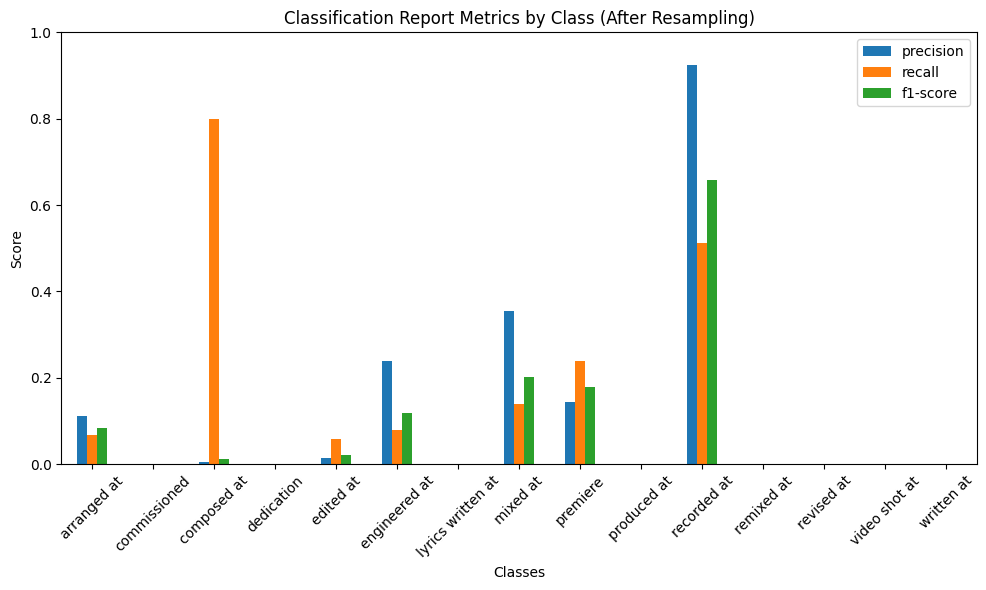

In [43]:
# Compute classification report as a dictionary
report_dict = classification_report(y_test_labels, y_pred_labels, output_dict=True)

# Convert report to a DataFrame for easier plotting
report_df = pd.DataFrame(report_dict).transpose()

# Remove aggregate scores; we keep only per-class metrics (precision, recall, f1-score)
classes = report_df.drop(index=["accuracy", "macro avg", "weighted avg"])

# Plot grouped bar chart
classes[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(10,6))
plt.title('Classification Report Metrics by Class (After Resampling)')
plt.ylabel('Score')
plt.xlabel('Classes')
plt.ylim(0,1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Ablation Test: We hypothesize type to be the most influential feature in prediction of services_offered. It should be informative to analyze how ablating the type feature affects model performance.

In [44]:
ablated_df = merged_df.drop(columns="type")
ablated_df.head()

,city,state,county,country,lifespan_years,status,services_offered
0,Los Jarales,NaN,NaN,VE,NaN,Active,recorded at
1,Plasky,Brussels Capital,Bruxelles-Capitale,BE,62.0,Active,recorded at
2,Dunluce Castle,Northern Ireland,Causeway Coast and Glens,GB,NaN,Active,recorded at
3,Saint Johns Eastern Orthodox Church,Tennessee,NaN,US,5.0,Ended,engineered at
4,Shimokitazawa Eki,NaN,NaN,JP,34.0,Active,recorded at


In [45]:
train_df1, test_df1 = train_test_split(ablated_df, test_size=0.2, random_state=42)


train_df1 = impute_df(train_df1)
test_df1 = impute_df(test_df1)

In [46]:


# Transform your training data using train_df1.
X_train = pd.get_dummies(train_df1.drop(columns=["services_offered", "lifespan_years"]), drop_first=True)
X_train["lifespan_years"] = train_df1["lifespan_years"]
X_train.columns = X_train.columns.astype(str).str.replace(r"[,\[\]<>]", "_", regex=True)

# Similarly, transform the test data using test_df1.
X_test = pd.get_dummies(test_df1.drop(columns=["services_offered", "lifespan_years"]), drop_first=True)
X_test["lifespan_years"] = test_df1["lifespan_years"]
X_test.columns = X_test.columns.astype(str).str.replace(r"[,\[\]<>]", "_", regex=True)

# Reindex X_test to align with X_train.
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# Encode the target variable from train_df1 and test_df1.
le = LabelEncoder()
y_train = le.fit_transform(train_df1["services_offered"])
y_test = le.fit_transform(test_df1["services_offered"])

# Set up the stratified 5-fold cross-validation.
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accuracy_list = []
precision_list = []
recall_list = []
f1_list = []

# Perform manual cross-validation.
for fold, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train), 1):
    X_train_fold = X_train.iloc[train_idx]
    y_train_fold = y_train[train_idx]
    X_val_fold = X_train.iloc[val_idx]
    y_val_fold = y_train[val_idx]
    
    model = xgb.XGBClassifier(random_state=42)
    model.fit(X_train_fold, y_train_fold)
    
    preds = model.predict(X_val_fold)
    
    acc = accuracy_score(y_val_fold, preds)
    prec = precision_score(y_val_fold, preds, average='weighted', zero_division=0)
    rec = recall_score(y_val_fold, preds, average='weighted')
    f1 = f1_score(y_val_fold, preds, average='weighted')
    
    accuracy_list.append(acc)
    precision_list.append(prec)
    recall_list.append(rec)
    f1_list.append(f1)
    
    print(f"Fold {fold}: Accuracy={acc:.4f}, Precision={prec:.4f}, Recall={rec:.4f}, F1 Score={f1:.4f}")

print("\nCross-Validation Results:")
print("Average Accuracy:", np.mean(accuracy_list))
print("Average Precision:", np.mean(precision_list))
print("Average Recall:", np.mean(recall_list))
print("Average F1 Score:", np.mean(f1_list))

# Train on the full training set and evaluate on the test set.
model = xgb.XGBClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

y_test_labels = le.inverse_transform(y_test)
y_pred_labels = le.inverse_transform(y_pred)


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Fold 1: Accuracy=0.6742, Precision=0.5543, Recall=0.6742, F1 Score=0.5576
Fold 2: Accuracy=0.6771, Precision=0.5973, Recall=0.6771, F1 Score=0.5635
Fold 3: Accuracy=0.6789, Precision=0.5886, Recall=0.6789, F1 Score=0.5615
Fold 4: Accuracy=0.6749, Precision=0.5584, Recall=0.6749, F1 Score=0.5579
Fold 5: Accuracy=0.6755, Precision=0.5485, Recall=0.6755, F1 Score=0.5563

Cross-Validation Results:
Average Accuracy: 0.6761115516687927
Average Precision: 0.5694279439490832
Average Recall: 0.6761115516687927
Average F1 Score: 0.5593728158447151


In [13]:
# Print the classification report across all target classes
print(classification_report(y_test_labels, y_pred_labels))

                   precision    recall  f1-score   support

      arranged at       0.00      0.00      0.00        15
     commissioned       0.00      0.00      0.00         3
      composed at       0.00      0.00      0.00        10
       dedication       0.00      0.00      0.00         1
        edited at       0.00      0.00      0.00        51
    engineered at       0.33      0.00      0.01       243
lyrics written at       0.00      0.00      0.00         2
         mixed at       0.39      0.02      0.04       659
         premiere       0.00      0.00      0.00        46
      produced at       0.00      0.00      0.00        48
      recorded at       0.68      0.99      0.80      2321
       remixed at       0.00      0.00      0.00        11
    video shot at       0.00      0.00      0.00        23
       written at       0.00      0.00      0.00         9

         accuracy                           0.67      3442
        macro avg       0.10      0.07      0.06      

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

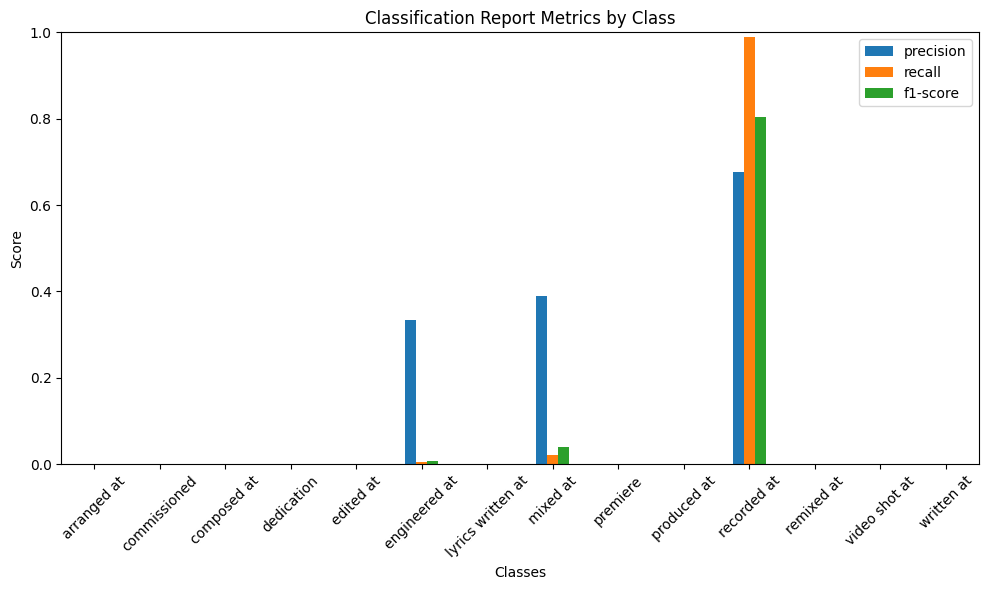

In [47]:
# Compute classification report as a dictionary
report_dict = classification_report(y_test_labels, y_pred_labels, output_dict=True)

# Convert report to a DataFrame for easier plotting
report_df = pd.DataFrame(report_dict).transpose()

# Remove aggregate scores; we keep only per-class metrics (precision, recall, f1-score)
classes = report_df.drop(index=["accuracy", "macro avg", "weighted avg"])

# Plot grouped bar chart
classes[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(10,6))
plt.title('Classification Report Metrics by Class')
plt.ylabel('Score')
plt.xlabel('Classes')
plt.ylim(0,1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Ablating the type feature resulted in slightly worse performance, however we hypothesized the impact to be more substantial. Interestingly for the majority target class, recorded at, recall improved and precision worsened. This indicates that after ablating what we hypothesized to be the most influential feature, type, the model became increasingly biased toward predicting the majority target class, recorded at.

This bias toward the majority class will be important to consider moving forward.

In [48]:
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings("ignore")

num_classes = len(np.unique(y_train))

# -----------------------------
# 2. Define Hyperparameter Grid
# -----------------------------
param_grid = {
    "learning_rate": [0.01, 0.1],
    "max_depth": [3, 5, 7],
    "n_estimators": [50, 100],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

# -----------------------------
# 3. Set Up Cross-Validation
# -----------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# -----------------------------
# 4. Manual Grid Search with Cross-Validation (Optimizing for F1 Score)
# -----------------------------
best_f1 = -1
best_params = None

for lr in param_grid["learning_rate"]:
    for max_depth in param_grid["max_depth"]:
        for n_estimators in param_grid["n_estimators"]:
            for subsample in param_grid["subsample"]:
                for colsample_bytree in param_grid["colsample_bytree"]:
                    params = {
                        "learning_rate": lr,
                        "max_depth": max_depth,
                        "n_estimators": n_estimators,
                        "subsample": subsample,
                        "colsample_bytree": colsample_bytree,
                        "random_state": 42,
                        "objective": "multi:softmax",
                        "num_class": num_classes
                    }
                    
                    cv_f1s = []
                    for train_idx, val_idx in cv.split(X_train, y_train):
                        X_train_fold = X_train.iloc[train_idx]
                        y_train_fold = y_train[train_idx]
                        X_val_fold = X_train.iloc[val_idx]
                        y_val_fold = y_train[val_idx]
                        
                        model = xgb.XGBClassifier(**params)
                        model.fit(X_train_fold, y_train_fold)
                        preds = model.predict(X_val_fold)
                        cv_f1s.append(f1_score(y_val_fold, preds, average='weighted', zero_division=0))
                    
                    mean_f1 = np.mean(cv_f1s)
                    if mean_f1 > best_f1:
                        best_f1 = mean_f1
                        best_params = params

# Train the best model on the entire training set
best_model = xgb.XGBClassifier(**best_params)
best_model.fit(X_train, y_train)

# Print best parameters and best cross-validation F1 score
print("Best Parameters:", best_params)
print("Best CV F1 Score:", best_f1)

# 5. Evaluate on Test Set
y_pred = best_model.predict(X_test)

test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
test_recall = recall_score(y_test, y_pred, average='weighted')
test_f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print("\nTest Set Evaluation:")
print("Accuracy:", test_accuracy)
print("Precision:", test_precision)
print("Recall:", test_recall)
print("F1 Score:", test_f1)


Best Parameters: {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 50, 'subsample': 1.0, 'colsample_bytree': 1.0, 'random_state': 42, 'objective': 'multi:softmax', 'num_class': 15}
Best CV F1 Score: 0.5589637021817746

Test Set Evaluation:
Accuracy: 0.6743172574084835
Precision: 0.5275437626804241
Recall: 0.6743172574084835
F1 Score: 0.5511497857290083


In [ ]:
# Print the classification report across all target classes
print(classification_report(y_test_labels, y_pred_labels))

                   precision    recall  f1-score   support

      arranged at       0.00      0.00      0.00        15
     commissioned       0.00      0.00      0.00         3
      composed at       0.00      0.00      0.00        10
       dedication       0.00      0.00      0.00         1
        edited at       0.00      0.00      0.00        51
    engineered at       0.00      0.00      0.00       243
lyrics written at       0.00      0.00      0.00         2
         mixed at       0.37      0.02      0.04       659
         premiere       0.00      0.00      0.00        46
      produced at       0.00      0.00      0.00        48
      recorded at       0.68      0.99      0.81      2321
       remixed at       0.00      0.00      0.00        11
    video shot at       0.00      0.00      0.00        23
       written at       0.00      0.00      0.00         9

         accuracy                           0.67      3442
        macro avg       0.07      0.07      0.06      

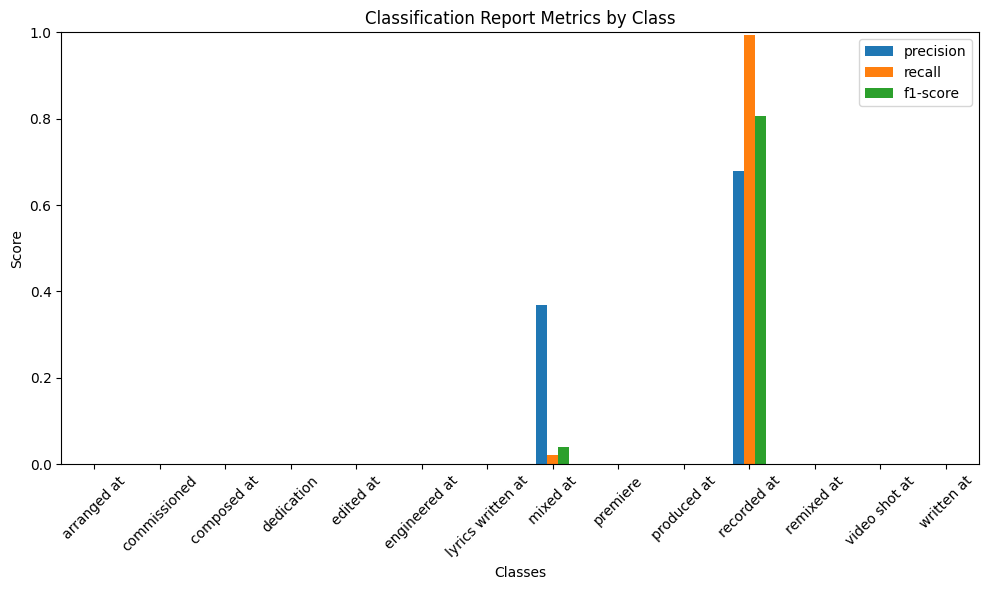

In [23]:
# Compute classification report as a dictionary
report_dict = classification_report(y_test_labels, y_pred_labels, output_dict=True)

# Convert report to a DataFrame for easier plotting
report_df = pd.DataFrame(report_dict).transpose()

# Remove aggregate scores; we keep only per-class metrics (precision, recall, f1-score)
classes = report_df.drop(index=["accuracy", "macro avg", "weighted avg"])

# Plot grouped bar chart
classes[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(10,6))
plt.title('Classification Report Metrics by Class (Precision )')
plt.ylabel('Score')
plt.xlabel('Classes')
plt.ylim(0,1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()